# Prelim

Notebook for ArchR preprocessing 

The results in the notebook were genreated using the 10X PBMC ATAC dataset: https://support.10xgenomics.com/single-cell-atac/datasets/1.2.0/atac_pbmc_10k_nextgem

<b>ArchR installation </b>

Install from [https://github.com/settylab/ArchR](https://github.com/settylab/ArchR)

```
library(devtools)
devtools::install_github("GreenleafLab/ArchR", ref="master", repos = BiocManager::repositories())
```

Update your ArchR with the customized version
```
R CMD INSTALL -l <PATH to R personal library> <path to Git clone >
```

Review the notebook `PBMC-RNA-standalone.ipynb` for setup instructions.
Install MACS2 for peak celling 
```
conda install -c bioconda macs2 
```



## Load data

Following files are required for using these tools:
1. ATAC fragments file. [Example](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scatac/atac_pbmc_10k_nextgem_fragments.tsv.gz)
2. Index for the fragments file. [Example](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scatac/atac_pbmc_10k_nextgem_fragments.tsv.gz.tbi)
3. Per barcode metrics. [Example](https://fh-pi-setty-m-eco-public.s3.us-west-2.amazonaws.com/single-cell-primers/scatac/atac_pbmc_10k_nextgem_singlecell.csv)

Use the above files to run ArchR using the ArchR preprocessing script: https://github.com/dpeerlab/SEACells/blob/main/notebooks/ArchR/ArchR-preprocessing-nfr-peaks.R


# Imports

In [1]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import SEACells

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


# Load data

This section loads all the results from ArchR to generate an Anndata object

## ATAC

In [11]:
data_dir = os.path.expanduser('<DATA DIR specified for ArchR>/export')

Load all the exported results from ArchR

### Peaks data

In [14]:
# Peaks data
from scipy.io import mmread
counts = mmread(data_dir + 'peak_counts/counts.mtx')

In [15]:
# Cell and peak information
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
peaks.head()

,seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,nearestGene,distToGeneStart,peakType,distToTSS,nearestTSS,GC,idx
chr1:751480-751980,chr1,751480,751980,501,*,20.60570,0.730,0.412,2,C5._.Rep1,LINC00115,9856,Distal,11171,uc001aau.3,0.2874,1
chr1:752473-752973,chr1,752473,752973,501,*,99.27760,0.956,0.893,2,C6._.Rep1,LINC00115,8863,Distal,10178,uc001aau.3,0.4790,2
chr1:757791-758291,chr1,757791,758291,501,*,4.07200,0.507,0.323,2,C4._.Rep1,LINC00115,3545,Distal,4860,uc001aau.3,0.5629,3
chr1:762058-762558,chr1,762058,762558,501,*,2.16582,0.045,0.001,2,C14._.Rep1,LINC00115,722,Promoter,593,uc001aau.3,0.5988,4
chr1:762677-763177,chr1,762677,763177,501,*,99.27760,0.956,0.893,2,C6._.Rep1,LINC00115,1341,Promoter,24,uc001aau.3,0.6886,5


In [16]:
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index
for col in peaks.columns:
    ad.var[col] = peaks[col]

In [17]:
ad.X = ad.X.tocsr()

In [18]:
ad

AnnData object with n_obs × n_vars = 9813 × 157132
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'

### SVD

In [19]:
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, : ].values

### Metadata

In [20]:
cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values

In [21]:
ad

AnnData object with n_obs × n_vars = 9813 × 157132
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    obsm: 'X_svd'

### Gene scores

In [25]:
# Gene scores
gene_scores = pd.read_csv(data_dir + 'gene_scores.csv', index_col=0).T

In [26]:
ad.obsm['GeneScores'] = gene_scores.loc[ad.obs_names, :].values
ad.uns['GeneScoresColums'] = gene_scores.columns.values

In [27]:
ad

AnnData object with n_obs × n_vars = 9813 × 157132
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    uns: 'GeneScoresColums'
    obsm: 'X_svd', 'GeneScores'

# Visualizations

In [29]:
# Leiden and UMAP
warnings.filterwarnings('ignore')
sc.pp.neighbors(ad, use_rep='X_svd')
sc.tl.umap(ad)
sc.tl.leiden(ad)
warnings.filterwarnings('default')

/usr/local/anaconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Sample' as categorical
/usr/local/anaconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Clusters' as categorical
/usr/local/anaconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be remo

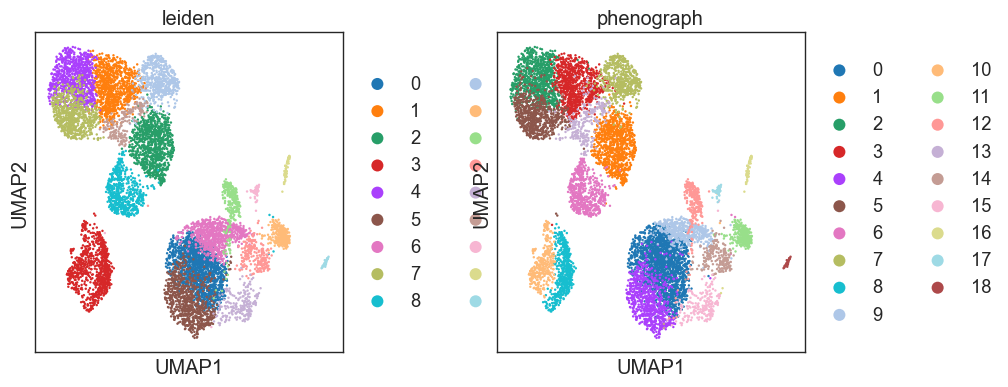

In [31]:
sc.pl.scatter(ad, basis='umap', color=['leiden', 'phenograph'])

# Save

 Save the anndata object for downstream usage

In [32]:
ad

AnnData object with n_obs × n_vars = 9813 × 157132
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    uns: 'GeneScoresColums', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'phenograph_colors'
    obsm: 'X_svd', 'GeneScores', 'X_umap'
    obsp: 'distances', 'connectivities'

In [28]:
ad.write(data_dir + '../../<PROJECT NAME>.h5ad')